# Copyright Netherlands eScience Center <br>
**Function     : Perturb Lorenz 84 system at weather time scales** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.11.30** <br>
**Last Update  : 2020.11.30** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to understand response of Lorens 84 model to perturbations at weather time scales. <br>

Three different types of uncertainties will vbe investigated here:<br>
- uncertainty of model outcome attributed to perturbation in initial conditions
- model uncertainty
- uncertainty related to extra/bias/trend terms

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# model type
model_type = 'lorenz84ex' # choose lorenz84 or lorenz84ex
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\paperFig'

In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>
- Testing external forcing terms F & G - uncertainty related to extra/bias/trend terms <br>
**starting point F=8.0, G=1.0** <br>
Ensemble variant G <br>
G = [1.0010 : 0.9990] **~0.1%**<br>
G_ex = [1.00010 : 0.99990] **~0.01%**<br>
G_ex = [1.000010 : 0.999990] **~0.001%**<br>
**starting point F=8.0, G=1.0, epsilon=0.4** <br>

In [5]:
    #################################################################################
    ###########                     Lorens 84 model                       ###########
    #################################################################################    
    def lorenz84(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model.
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        Physical interpretation:
        x represents the intensity of the symmetric globe-encircling westerly
        wind current, and also the poleward temperature gradient, which is assumed
        to be in permanent equilibrium with it.
        
        y and z represent the cosine and sine phases of a chain of superposed
        large-scale eddies, which transport heat poleward at a rate proportional
        to the square of their amplitude, and transport no angular momentum at all.
        (Lorenz identifies the eddies with Rossby waves!)
        
        xy and xz these nonlinear contributions represent amplification of the
        eddies through interaction with the westerly current
        
        -y**2 and -z**2 are the expense of the westerly current for the amplification
        of the eddies.
        
        -bxz and bxy represent displacement of the eddies by the westerly current.
        
        b allows the amplification (should be b>1.0)
        
        a represents mechanical and thermal damping(should be a>1.0).
        
        aF represents symmetric thermal forcing
        G represents asymmetric thermal forcing
        
        !@#$%^&* The variables have been scaled so that the coefficients are unity.
        
        Freire, J. G., Bonatto, C., DaCamara, C. C., & Gallas, J. A. (2008).
        Multistability, phase diagrams, and intransitivity in the Lorenz-84
        low-order atmospheric circulation model. Chaos: An Interdisciplinary
        Journal of Nonlinear Science, 18(3), 033121.
        """
        dx = - y**2 - z**2 - a * x + a * F
        dy = x * y - b * x * z - y + G
        dz = b * x * y + x * z - z
        
        return dx, dy, dz
    
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

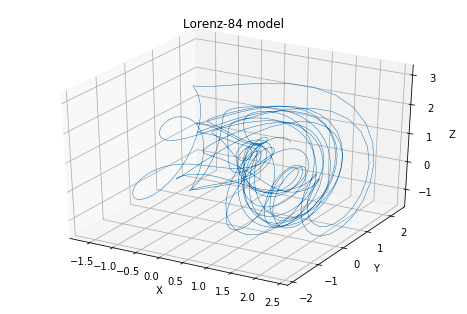

<Figure size 432x288 with 0 Axes>

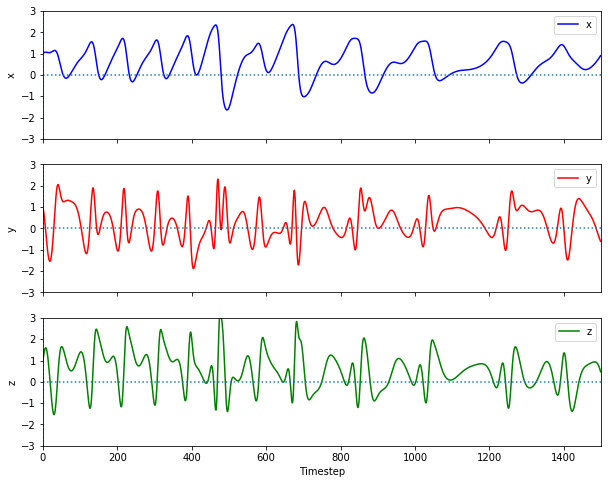

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    
    # std
    x_std = np.std(x[-test_len:])
    y_std = np.std(y[-test_len:])
    z_std = np.std(z[-test_len:])

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [9]:
    #################################################################################
    ###########                 perturb initial conditions                ###########
    #################################################################################
    # percentage of perturbation
    x_pool = np.array([-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], dtype=float)
    x_pool_per = ["5%", "10%", "15%", "20%", "25%", "30%"]

In [10]:
    #######################################################################
    #######          Perturbed Lorenz 84 model experiments          #######
    #######                perturb initial conditions               #######
    #######################################################################
    step_lead = 42+1 #include initial values
    perturb_lorenz = np.zeros((len(x_pool), 3, test_len, step_lead), dtype=float)
    
    for i in range(len(x_pool)):
        for j in range(test_len):
            perturb_lorenz[i,0,j,0] = x[-test_len-1+j] + x[-test_len-1+j] * x_pool[i]
            perturb_lorenz[i,1,j,0] = y[-test_len-1+j]
            perturb_lorenz[i,2,j,0] = z[-test_len-1+j]
            
            t_perturb = dt * (num_steps-test_len+j)
            
            for k in range(step_lead-1):
                dx, dy, dz = lorenz84_ex(perturb_lorenz[i,0,j,k], perturb_lorenz[i,1,j,k],
                                         perturb_lorenz[i,2,j,k], t, a, b ,F, G, epsilon)
                perturb_lorenz[i,0,j,k+1] = perturb_lorenz[i,0,j,k] + (dx * dt)
                perturb_lorenz[i,1,j,k+1] = perturb_lorenz[i,1,j,k] + (dy * dt)
                perturb_lorenz[i,2,j,k+1] = perturb_lorenz[i,2,j,k] + (dz * dt)
                t_perturb += dt

===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

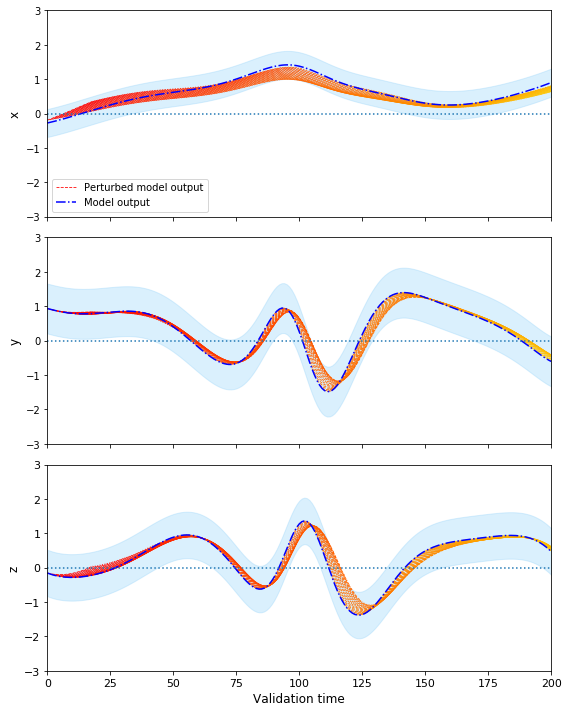

In [12]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - timeseries   ########
    ###################################################################################
    index_lead = np.arange(test_len+step_lead+1)
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 51)
    
    colormap=cm.autumn(range(test_len))
    
    # target lead steps 2, 6, 16, 42
    display_upto = 18
    
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(8, 10, forward=True)
    

    # obs std band
    ax1.fill_between(index[:test_len+1], x[-test_len-1:] + x_std, x[-test_len-1:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index[:test_len+1], y[-test_len-1:] + y_std, y[-test_len-1:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index[:test_len+1], z[-test_len-1:] + z_std, z[-test_len-1:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    # Perturbed Lorenz 84 model output
    for i in range(test_len):
        if i == 0:
            ax1.plot(index[i:i+display_upto+1], perturb_lorenz[0, 0, i, :display_upto+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8, label="Perturbed model output")
        else:
            ax1.plot(index[i:i+display_upto+1], perturb_lorenz[0, 0, i, :display_upto+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8)            
        ax2.plot(index[i:i+display_upto+1], perturb_lorenz[0, 1, i, :display_upto+1],
                 color=colormap[i], linestyle='dashed', linewidth = 0.8)
        ax3.plot(index[i:i+display_upto+1], perturb_lorenz[0, 2, i, :display_upto+1],
                 color=colormap[i], linestyle='dashed', linewidth = 0.8)
    # obs
    ax1.plot(index[:test_len+1], x[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax2.plot(index[:test_len+1], y[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax3.plot(index[:test_len+1], z[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')

    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=1)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Validation time", fontsize=12)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.tight_layout()

    plt.show()
    fig02.savefig(os.path.join(output_path,'perturb_initialConditions_lorenz84_series_onlyOne.png'),dpi=150) 

===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

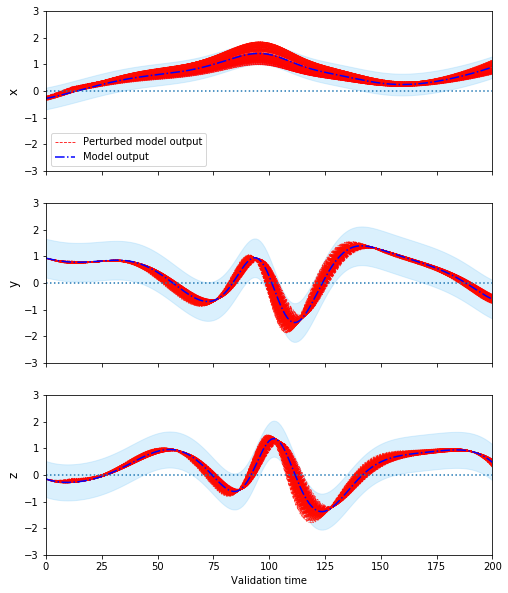

In [15]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - timeseries   ########
    ###################################################################################
    index = np.arange(test_len+step_lead+1)
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 51)
    
    colormap=cm.autumn(range(test_len))
    
    # target lead steps 6, 12, 18
    step_lead_display = 12
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(8, 10, forward=True)
    

    # obs std band
    ax1.fill_between(index[:test_len+1], x[-test_len-1:] + x_std, x[-test_len-1:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index[:test_len+1], y[-test_len-1:] + y_std, y[-test_len-1:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index[:test_len+1], z[-test_len-1:] + z_std, z[-test_len-1:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    # each member
    for i in range(len(x_pool)):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index[j:j+step_lead_display+1], perturb_lorenz[i, 0, j, :step_lead_display+1],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8, label="Perturbed model output")
            else:
                ax1.plot(index[j:j+step_lead_display+1], perturb_lorenz[i, 0, j, :step_lead_display+1],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)                
            ax2.plot(index[j:j+step_lead_display+1], perturb_lorenz[i, 1, j, :step_lead_display+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8)
            ax3.plot(index[j:j+step_lead_display+1], perturb_lorenz[i, 2, j, :step_lead_display+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8)
        
    # obs
    ax1.plot(index[:test_len+1], x[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax2.plot(index[:test_len+1], y[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax3.plot(index[:test_len+1], z[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')

    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10}, ncol=1)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Validation time")

    plt.show()
    fig03.savefig(os.path.join(output_path,'perturb_initialConditions_lorenz84_series_ens_leadTime{}.png'.format(step_lead_display)),dpi=150) 

In [16]:
    #################################################################################
    ###########                 perturb model parameters                  ###########
    #################################################################################
    # percentage of perturbation
    a_pool = np.array([-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], dtype=float)
    a_pool_per = ["5%", "10%", "15%", "20%", "25%", "30%"]

In [18]:
    #######################################################################
    #######          Perturbed Lorenz 84 model experiments          #######
    #######                 perturb model parameters                #######
    #######################################################################
    step_lead = 42+1 #include initial values
    perturb_lorenz_a = np.zeros((len(a_pool), 3, test_len, step_lead), dtype=float)
    
    for i in range(len(a_pool)):
        for j in range(test_len):
            perturb_lorenz_a[i,0,j,0] = x[-test_len-1+j]
            perturb_lorenz_a[i,1,j,0] = y[-test_len-1+j]
            perturb_lorenz_a[i,2,j,0] = z[-test_len-1+j]
            
            a_perturb = a + a * a_pool[i]
            
            t_perturb = dt * (num_steps-test_len+j)
            
            for k in range(step_lead-1):
                dx, dy, dz = lorenz84_ex(perturb_lorenz_a[i,0,j,k], perturb_lorenz_a[i,1,j,k],
                                         perturb_lorenz_a[i,2,j,k], t, a_perturb, b ,F, G, epsilon)
                perturb_lorenz_a[i,0,j,k+1] = perturb_lorenz_a[i,0,j,k] + (dx * dt)
                perturb_lorenz_a[i,1,j,k+1] = perturb_lorenz_a[i,1,j,k] + (dy * dt)
                perturb_lorenz_a[i,2,j,k+1] = perturb_lorenz_a[i,2,j,k] + (dz * dt)
                t_perturb += dt

===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

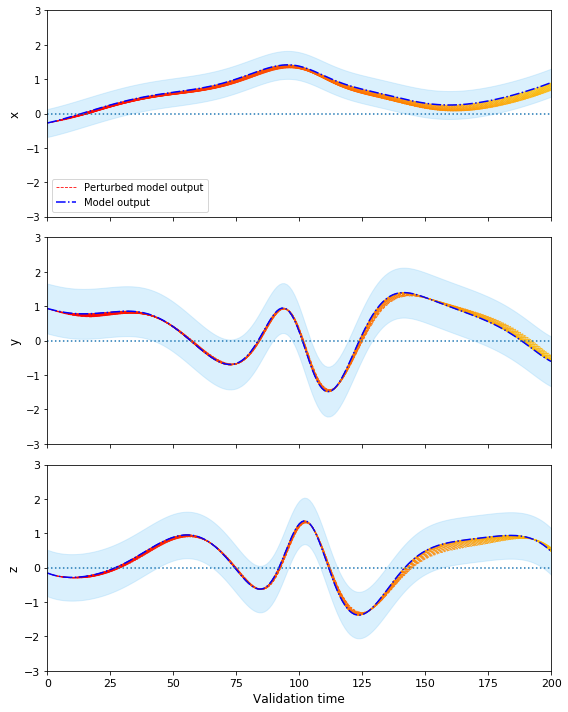

In [19]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - timeseries   ########
    ###################################################################################
    index_lead = np.arange(test_len+step_lead+1)
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 51)
    
    colormap=cm.autumn(range(test_len))
    
    # target lead steps 2, 6, 16, 42
    display_upto = 18
    
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(8, 10, forward=True)
    

    # obs std band
    ax1.fill_between(index[:test_len+1], x[-test_len-1:] + x_std, x[-test_len-1:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index[:test_len+1], y[-test_len-1:] + y_std, y[-test_len-1:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index[:test_len+1], z[-test_len-1:] + z_std, z[-test_len-1:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    # Perturbed Lorenz 84 model output
    for i in range(test_len):
        if i == 0:
            ax1.plot(index[i:i+display_upto+1], perturb_lorenz_a[0, 0, i, :display_upto+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8, label="Perturbed model output")
        else:
            ax1.plot(index[i:i+display_upto+1], perturb_lorenz_a[0, 0, i, :display_upto+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8)            
        ax2.plot(index[i:i+display_upto+1], perturb_lorenz_a[0, 1, i, :display_upto+1],
                 color=colormap[i], linestyle='dashed', linewidth = 0.8)
        ax3.plot(index[i:i+display_upto+1], perturb_lorenz_a[0, 2, i, :display_upto+1],
                 color=colormap[i], linestyle='dashed', linewidth = 0.8)
    # obs
    ax1.plot(index[:test_len+1], x[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax2.plot(index[:test_len+1], y[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax3.plot(index[:test_len+1], z[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')

    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10.0}, ncol=1)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Validation time", fontsize=12)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.tight_layout()

    plt.show()
    fig04.savefig(os.path.join(output_path,'perturb_modelParameter_lorenz84_series_onlyOne.png'),dpi=150) 

===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

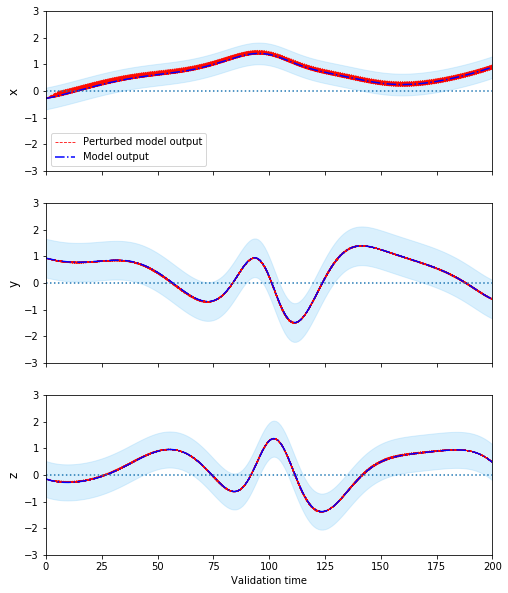

In [22]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - timeseries   ########
    ###################################################################################
    index = np.arange(test_len+step_lead+1)
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 51)
    
    colormap=cm.autumn(range(test_len))
    
    # target lead steps 6, 12, 18
    step_lead_display = 6
    
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(8, 10, forward=True)
    

    # obs std band
    ax1.fill_between(index[:test_len+1], x[-test_len-1:] + x_std, x[-test_len-1:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index[:test_len+1], y[-test_len-1:] + y_std, y[-test_len-1:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index[:test_len+1], z[-test_len-1:] + z_std, z[-test_len-1:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    # each member
    for i in range(len(x_pool)):
        for j in range(test_len):
            if i == 0 and j == 0:
                ax1.plot(index[j:j+step_lead_display+1], perturb_lorenz_a[i, 0, j, :step_lead_display+1],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8, label="Perturbed model output")
            else:
                ax1.plot(index[j:j+step_lead_display+1], perturb_lorenz_a[i, 0, j, :step_lead_display+1],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)                
            ax2.plot(index[j:j+step_lead_display+1], perturb_lorenz_a[i, 1, j, :step_lead_display+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8)
            ax3.plot(index[j:j+step_lead_display+1], perturb_lorenz_a[i, 2, j, :step_lead_display+1],
                     color=colormap[i], linestyle='dashed', linewidth = 0.8)
        
    # obs
    ax1.plot(index[:test_len+1], x[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax2.plot(index[:test_len+1], y[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')
    ax3.plot(index[:test_len+1], z[-test_len-1:], color='blue', linestyle='dashdot', label='Model output')

    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 10}, ncol=1)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=5)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xlabel("Validation time")

    plt.show()
    fig05.savefig(os.path.join(output_path,'perturb_modelParameter_lorenz84_series_ens_leadTime{}.png'.format(step_lead_display)),dpi=150) 